In [10]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from sklearn import metrics, model_selection
from sklearn.model_selection import train_test_split,validation_curve,learning_curve
import mlflow
from sklearn.preprocessing import StandardScaler
import mlflow.sklearn
from mlflow.models.signature import infer_signature
from mlflow.tracking import MlflowClient
from sklearn.metrics import *
import pycaret.classification as pc
import seaborn as sns
from statsmodels.tsa.stattools import ccf




if 'inline_rc' not in dir():
    inline_rc = dict(mpl.rcParams)

SEED = 10

np.random.seed(SEED)

# Reset do estilo de cores do matplotlib 

In [11]:
# reset matplotlib

mpl.rcParams.update(inline_rc)
font = {'size'   : 14}
mpl.rc('font', **font)
lines = {'linewidth' : 3}
mpl.rc('lines', **lines)

In [12]:
registered_model_name = 'modelo_kobe'
model_version = -1 # recuperar a ultima versao
nexamples = 4
development = 'data/raw/dataset_kobe_dev.parquet'
prod = 'data/raw/dataset_kobe_prod.parquet'
min_precision = 0.55


# Experimento de Classificação de Lançamentos 

In [13]:
# Para usar o sqlite como repositorio
mlflow.set_tracking_uri("sqlite:///mlruns.db")

experiment_name = 'Monitoramento'
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    experiment_id = mlflow.create_experiment(experiment_name)
    experiment = mlflow.get_experiment(experiment_id)
experiment_id = experiment.experiment_id


# Leitura e Tratamento dos Dados 

In [14]:
col = ['lat','lon', 'minutes_remaining', 'period','shot_distance',
'playoffs', 'shot_made_flag']
col_2 = ['lat','lon', 'minutes_remaining', 'period','shot_distance',
'playoffs']

target = 'shot_made_flag'

test_size=0.2
cvfold = model_selection.StratifiedKFold(n_splits = 10, random_state = 0, shuffle=True)

with mlflow.start_run(experiment_id=experiment_id, run_name = 'Preparacao_Dados'):
    df = pd.read_parquet(development)
    df = df[col].copy()
    mlflow.log_metric('Linha_sem_dropna', df.shape[0])
    print(f'Com modelos faltantes {df.shape}')

    df = df.dropna()
    print(f'Sem modelos faltantes {df.shape}')

    df.to_parquet('data/processed/data_filtered.parquet')

    X = df.drop(columns=target)
    Y = df[target].copy()

    # Separar parte para compor a base de operacao
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, stratify=df[target])

    x_train[target] = y_train
    x_test[target]= y_test

    x_train.to_parquet('data/processed/base_train.parquet')
    x_test.to_parquet('data/processed/base_test.parquet')
    
    # LOG DE PARAMETROS DO MODELO
    # LOG DE PARAMETROS DO MODELO
    mlflow.log_param('Perc_test', test_size)
    mlflow.log_param('Colunas', col)


    # LOG DE METRICAS GLOBAIS
    mlflow.log_metric('Linhas_dev', df.shape[0])
    mlflow.log_metric('Linhas_train', x_train.shape[0])
    mlflow.log_metric('Linhas_test', x_test.shape[0])

    
mlflow.end_run()

print('== Bases de Dados ==')
print(f'data {df.shape}')
print(f'data_operation {x_test.shape}')
print(f'Columns: {df.columns}')

Com modelos faltantes (24271, 7)
Sem modelos faltantes (20285, 7)
== Bases de Dados ==
data (20285, 7)
data_operation (4057, 7)
Columns: Index(['lat', 'lon', 'minutes_remaining', 'period', 'shot_distance',
       'playoffs', 'shot_made_flag'],
      dtype='object')


# Estudo da Base

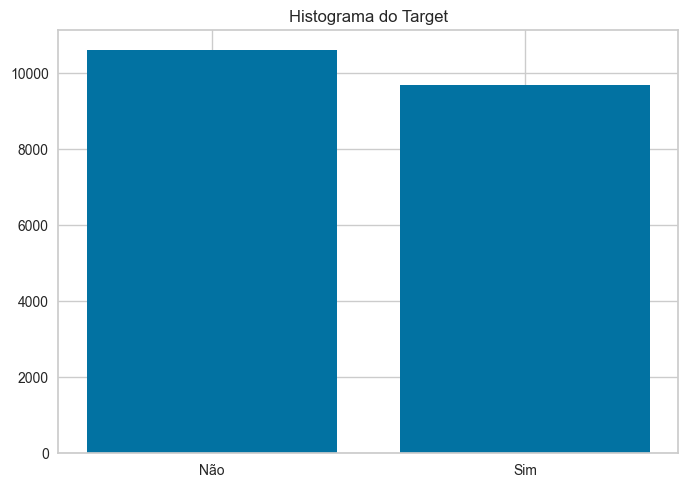

In [15]:
plt.bar(x=df[target].value_counts(normalize=False).index,
        height=df[target].value_counts(normalize=False).values)
plt.title('Histograma do Target')
plt.xticks(ticks=[0, 1], labels=['Não', 'Sim'])
plt.show()

In [16]:
# plt.bar(x=x_train[target].value_counts(normalize=False).index,
#         height=x_train[target].value_counts(normalize=False).values)
# plt.title('Histograma do Target Treino')
# plt.xticks(ticks=[0, 1], labels=['Não', 'Sim'])
# plt.show()

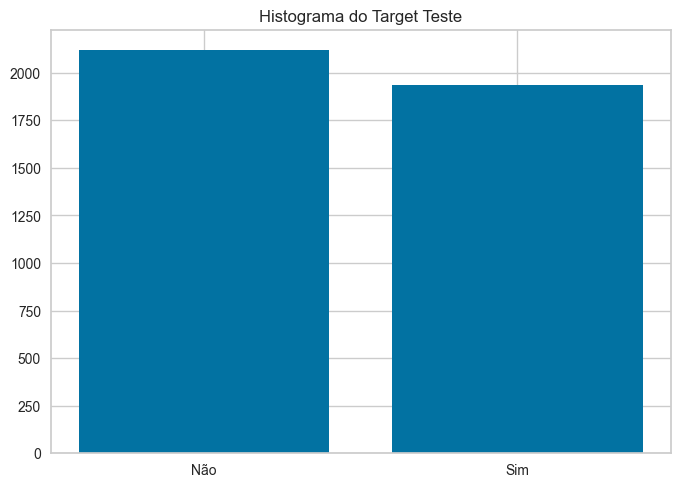

In [17]:
plt.bar(x=x_test[target].value_counts(normalize=False).index,
        height=x_test[target].value_counts(normalize=False).values)
plt.title('Histograma do Target Teste')
plt.xticks(ticks=[0, 1], labels=['Não', 'Sim'])
plt.show()

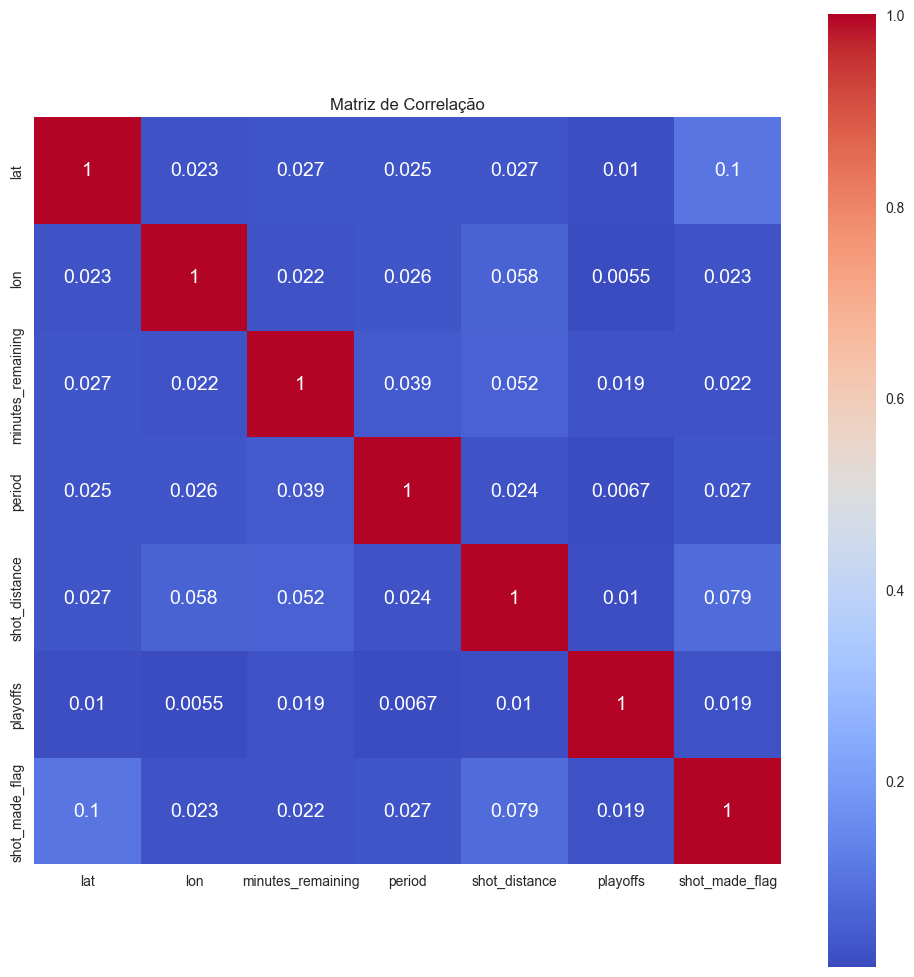

In [18]:
ccf_matrix = pd.DataFrame(
    np.zeros([df.shape[1], df.shape[1]]),
    columns=df.columns,
    index=df.columns
)

for col in ccf_matrix.columns:
    for idx in ccf_matrix.index:
        result = ccf(df[idx], df[col], adjusted=False)
        ccf_matrix.loc[idx, col] = max(result)
        ccf_matrix.loc[col,idx] = max(result)

plt.subplots(figsize=(10,10))
sns.heatmap(ccf_matrix,
            xticklabels=ccf_matrix.columns,
            yticklabels=ccf_matrix.columns,
            cmap="coolwarm",
            square=True, annot=True)
plt.title('Matriz de Correlação')
plt.tight_layout()
plt.show()

# Função de Avaliação do Modelo

In [19]:
def avaliacao_model(model, nexamples, model_version, min_precision, registered_model_name, target, x_train):

    # Avaliação da precisão do modelo
    pred_holdout = pc.predict_model(model, raw_score=True)
    pred_holdout.drop('prediction_score_0', axis=1, inplace=True)
    pred_holdout.rename({'prediction_score_1': 'prediction_score'}, axis=1, inplace=True)
    pr = metrics.precision_score(pred_holdout[target], pred_holdout['prediction_label'])

    # Criacao do cliente do servico MLFlow
    client = MlflowClient()
    if pr > min_precision:
        print(f'=> Aceito o modelo com precisão {pr} (min: {min_precision})')
        # Exportação para Log e  registro
        pc.save_model(model, f'./{registered_model_name}') 
        # Carrega novamente o pipeline + bestmodel
        model_pipe = experiment.load_model(f'./{registered_model_name}')
        # Assinatura do Modelo Inferida pelo MLFlow
        model_features = list(x_train.drop(target, axis=1).columns)
        inf_signature = infer_signature(x_train[model_features], model_pipe.predict(x_train.drop(target, axis=1)))
        # Exemplo de entrada para o MLmodel
        input_example = {x: x_train[x].values[:nexamples] for x in model_features}
        # Log do pipeline de modelagem do sklearn e registrar como uma nova versao
        mlflow.sklearn.log_model(
            sk_model=model_pipe,
            artifact_path="sklearn-model",
            registered_model_name=registered_model_name,
            signature = inf_signature,
            input_example = input_example,
            pyfunc_predict_fn = 'predict_proba'
        )
        # Criacao do cliente do servico MLFlow e atualizacao versao modelo
        if model_version == -1:
            model_version = client.get_latest_versions(registered_model_name)[-1].version
        # Registrar o modelo como staging
        client.transition_model_version_stage(
            name=registered_model_name,
            version=model_version, # Verificar com usuario qual versao
            stage="Staging"
        )
        # Atualizacao do alias do modelo
        client.set_registered_model_alias(
            name=registered_model_name, 
            alias=f'staging', 
            version=model_version
        )
        
        print(f'Modelo {registered_model_name} version {model_version} movido para Staging.')

    else:
        print(f'=> Rejeitado o modelo com precisão {pr} (min: {min_precision})')

    # LOG DE PARAMETROS DO MODELO
    mlflow.log_param("precisao_minima", min_precision)

    # LOG DE METRICAS GLOBAIS
    mlflow.log_metric("new_version", model_version)
    mlflow.log_metric("Avaliação precisao do Tune", pr)


# Funções de Plot Gráficos

In [20]:
cvfold = model_selection.StratifiedKFold(n_splits = 10, random_state = 0, shuffle=True)

# Salvar a Curva de Validação no MLFlow
def plot_parameter_validation_curve(X, Y, param_name, grid_search,
                                    model, model_name, scoring,
                                    logx):
    print('Parameter:', param_name)
    print('GridSearch:', grid_search[param_name])
    print('Scoring:', scoring)
    plt.figure(figsize=(6,4))
    train_scores, test_scores = validation_curve(model,
                                                 X = X.drop(target, axis=1), 
                                                 y = Y, 
                                                 param_name=param_name, 
                                                 param_range= grid_search[param_name],
                                                 scoring=scoring,
                                                 cv=cvfold,
                                                 n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.title("Curva Validação Modelo " + model_name)
    plt.xlabel(param_name)
    plt.ylabel("Score ("+scoring+")")
    if logx:
        plt.semilogx(grid_search[param_name], train_scores_mean,'-o', label="Treino",
                     color="darkorange", lw=2)
        plt.semilogx(grid_search[param_name], test_scores_mean,'-o', label="Validação-Cruzada",
                     color="navy", lw=2)
    else:
        plt.plot(grid_search[param_name], train_scores_mean,'-o', label="Treino",
                     color="darkorange", lw=2)
        plt.plot(grid_search[param_name], test_scores_mean,'-o', label="Validação-Cruzada",
                 color="navy", lw=2)
    plt.fill_between(grid_search[param_name], train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=2)
    plt.fill_between(grid_search[param_name], test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=2)
    plt.legend(loc='best')
    plt.grid(True)
    plt.savefig(f'Curva de Validacao {model_name}.png')
    mlflow.log_artifact(f'Curva de Validacao {model_name}.png')
    os.remove(f'Curva de Validacao {model_name}.png')

    # plt.show() 
    # return plt.gca()

# Salvar a Curva de Aprendizado no MLFlow
def plot_learning_curve(X, Y, model, model_name, scoring, train_sizes):
    plt.figure(figsize=(6,4))
    ax = plt.gca()
        
    ax.set_title('Curva de Aprendizado (%s)'%model_name)
    ax.set_xlabel("Exemplos do Treino")
    ax.set_ylabel("Score (" + scoring + ")")

    train_sizes, train_scores, test_scores = learning_curve(model,
                                                            X =  X.drop(target, axis=1),
                                                            y = Y,
                                                            cv=cvfold,
                                                            n_jobs=-1,
                                                            train_sizes=train_sizes,
                                                            scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # Plot learning curve
    ax.grid()
    ax.plot(train_sizes, train_scores_mean, 'o-', color="darkorange",
                 label="Treino")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="navy",
                 label="Validação-cruzada")
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="darkorange")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="navy")
    ax.legend(loc="best")
    plt.savefig(f'Curva de Aprendizado {model_name}.png')
    mlflow.log_artifact(f'Curva de Aprendizado {model_name}.png')
    os.remove(f'Curva de Aprendizado {model_name}.png')
    # return ax

 
# Salvar Plots dos modelos no MLFlow com Pycaret
def plot_images(model, model_name, classification):
    for plot_type in classification:
        print(f'=> Applying plot {plot_type}')
        
        artifact_name = pc.plot_model(model, plot=plot_type, save=True)
        
        old_name = f'{artifact_name}'
        new_name = f'{model_name}_{plot_type}.png'
        
        if os.path.exists(new_name):
            os.remove(new_name)
        
        os.rename(old_name, new_name)
        
        mlflow.log_artifact(new_name)
        os.remove(new_name)


def evaluate_and_log_model(X, model_name):
    # Gera o relatório de classificação
    report_dict = metrics.classification_report(X[target], X['prediction_label'], output_dict=True)    
    report_df = pd.DataFrame(report_dict).transpose()


    # Inicia um experimento MLflow e registra o relatório como um artefato
    # Salva DataFrame para CSV
    csv_path = f"{model_name}_classification_report.csv"
    report_df.to_csv(csv_path, index=True)
    
    # Loga o arquivo CSV como um artefato
    mlflow.log_artifact(csv_path)

    # Limpeza: remove o arquivo CSV local se não for mais necessário
    os.remove(csv_path)




In [21]:
# !mlflow ui --backend-store-uri sqlite:///mlruns.db
# mlflow.end_run()

# Treinamento do Modelo

,Description,Value
0,Session id,123
1,Target,shot_made_flag
2,Target type,Binary
3,Original data shape,"(16228, 7)"
4,Transformed data shape,"(15578, 7)"
5,Transformed train set shape,"(12332, 7)"
6,Transformed test set shape,"(3246, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.5828,0.5981,0.4418,0.5831,0.5024,0.1550,0.1595,0.5740
dt,Decision Tree Classifier,0.5401,0.5202,0.5823,0.5161,0.5470,0.0832,0.0839,0.2527


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.5823,0.5991,0.4442,0.5816,0.5037,0.1541,0.1582


=> Applying plot auc


=> Applying plot pr


=> Applying plot confusion_matrix


=> Applying plot class_report


=> Applying plot threshold


=> Applying plot feature


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.5259,0.5066,0.5681,0.5029,0.5335,0.0551,0.0556


=> Applying plot auc


=> Applying plot pr


=> Applying plot confusion_matrix


=> Applying plot class_report


=> Applying plot threshold


=> Applying plot feature


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5935,0.6032,0.4673,0.6173,0.5319,0.1847,0.1903
1,0.5612,0.5516,0.4090,0.5342,0.4633,0.1031,0.1057
2,0.5577,0.5880,0.3991,0.5898,0.4761,0.1174,0.1242
3,0.6051,0.6339,0.4626,0.6387,0.5366,0.2076,0.2158
4,0.5820,0.6074,0.4602,0.5805,0.5134,0.1555,0.1588
5,0.5751,0.5790,0.4314,0.5527,0.4846,0.1323,0.1353
6,0.5670,0.5944,0.4339,0.5404,0.4813,0.1172,0.1193
7,0.5884,0.6121,0.4409,0.5812,0.5014,0.1621,0.1666
8,0.5699,0.5835,0.4192,0.5390,0.4716,0.1185,0.1211


Fitting 15 folds for each of 10 candidates, totalling 150 fits


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.5826,0.5987,0.4442,0.5821,0.5038,0.1547,0.1589


=> Aceito o modelo com precisão 0.5820642978003384 (min: 0.55)
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded
Modelo modelo_kobe version 1 movido para Staging.


Successfully registered model 'modelo_kobe'.
Created version '1' of model 'modelo_kobe'.


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.5826,0.5987,0.4442,0.5821,0.5038,0.1547,0.1589


=> Applying plot auc


=> Applying plot pr


=> Applying plot confusion_matrix


=> Applying plot class_report


=> Applying plot threshold


=> Applying plot feature


Parameter: C
GridSearch: [0.01, 0.1, 1, 10]
Scoring: accuracy
Parameter: max_depth
GridSearch: [2, 3, 4, 5, 6, 7, 8]
Scoring: accuracy


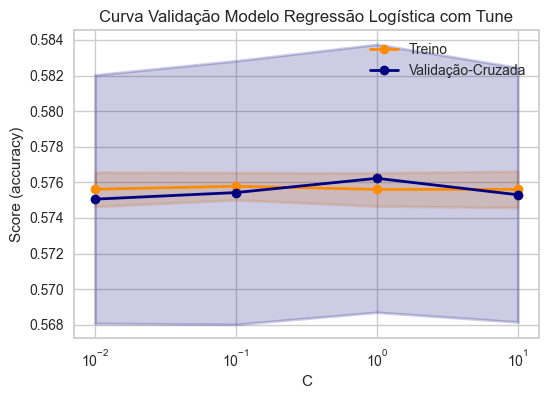

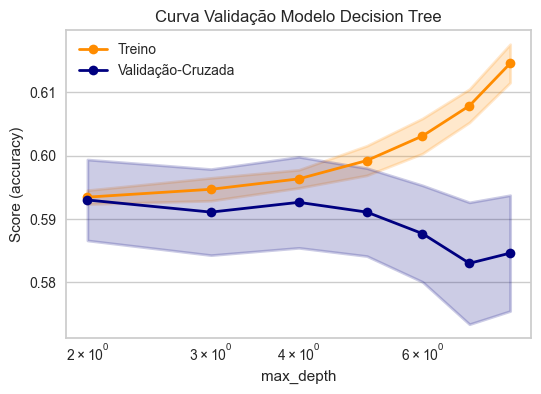

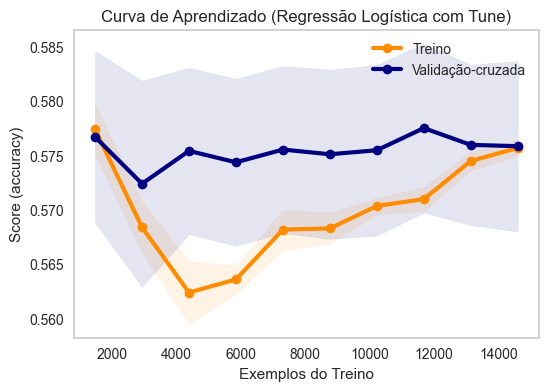

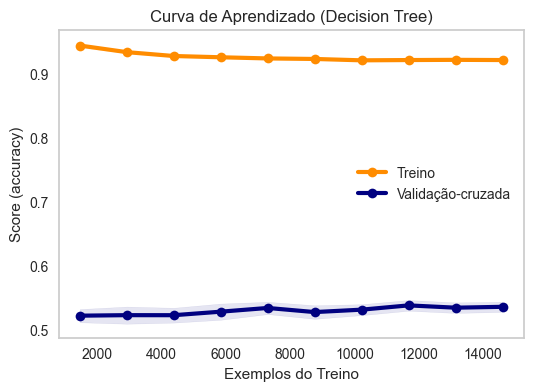

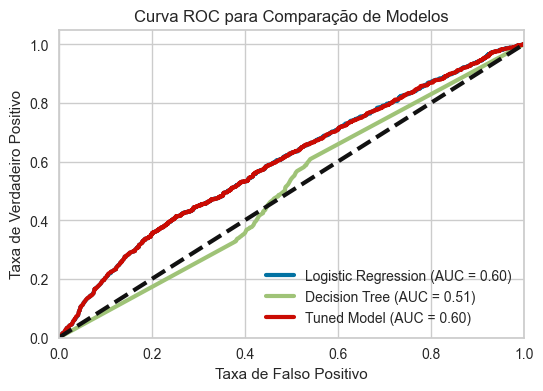

In [22]:
train_sizes = np.linspace(.1, 1.0, 10)
probability_threshold = 0.5
cross_validation = True
nexamples = 5
model_version = -1


classification_plots= [ 'auc','pr','confusion_matrix',
                         'class_report', 
                        'threshold',
                        'feature',
                       ]

with mlflow.start_run(experiment_id=experiment_id, run_name = 'Treinamento'):
    experiment = pc.setup(session_id=123,
                    data = x_train, # Configurações de dados
                    train_size=0.8,
                    target = target,
                    profile = False, # Analise interativa de variaveis
                    fold_strategy = 'kfold', # Validação cruzada
                    fold = 15,
                    normalize = True,  # Normalização, transformação e remoção de variáveis
                    transformation = True, 
                    remove_multicollinearity = True,
                    remove_outliers = True,
                    multicollinearity_threshold = 0.9,
                    bin_numeric_features = None, # Binarizacao de variaveis
                    log_experiment = False, # Logging dos experimentos e afins
                    experiment_name = 'Treinamento',
                )

    best_model = experiment.compare_models(sort='Accuracy', include=['lr', 'dt'], n_select=2)


    ################## MODELO 1
    yhat_test_rl = experiment.predict_model(best_model[0], raw_score=True)
    plot_images(best_model[0], 'Regressão Logística', classification_plots)
    evaluate_and_log_model(yhat_test_rl,"Regressão Logística")

    
    # SALVAR OS MODELOS
    yhat_test_rl.to_parquet('data/processed/model_rl.parquet')
    mlflow.log_artifact('data/processed/model_rl.parquet')

    # LOG LOSS DO MODELO REGRESSÃO LOGÍSTICA
    # F1 SCORE DO MODELO REGRESSÃO LOGÍSTICA
    mlflow.log_metric('reg_log_loss',log_loss(yhat_test_rl.shot_made_flag, yhat_test_rl.prediction_label))
    mlflow.log_metric('reg_f1', f1_score(yhat_test_rl.shot_made_flag, yhat_test_rl.prediction_label))


    ################## MODELO 2
    yhat_test_dt = experiment.predict_model(best_model[1], raw_score=True)
    plot_images(best_model[1], 'Árvore de Decisão', classification_plots)
    evaluate_and_log_model(yhat_test_dt,"Árvore de Decisão")


    # SALVAR OS MODELOS
    yhat_test_dt.to_parquet('data/processed/model_dt.parquet')
    mlflow.log_artifact('data/processed/model_dt.parquet')

    # LOG LOSS DO MODELO DE ÁRVORE DE DECISÃO
    # F1 SCORE DO MODELO DE ÁRVORE DE DECISÃO
    mlflow.log_metric('dt_log_loss',log_loss(yhat_test_dt.shot_made_flag, yhat_test_dt.prediction_label))
    mlflow.log_metric('dt_f1', f1_score(yhat_test_dt.shot_made_flag, yhat_test_dt.prediction_label))




    ################## Tuned Model MODELO 1
    tuned_model = pc.tune_model(best_model[0],
                                optimize = 'Accuracy',
                                search_library = 'scikit-learn',
                                search_algorithm = 'random',
                                n_iter = 10)

    # AVALIAÇÃO DO MODELO
    avaliacao_model(
        tuned_model, 
        nexamples, 
        model_version,  
        min_precision, 
        registered_model_name, 
        target, 
        x_train
    )

    yhat_test_tune = experiment.predict_model(tuned_model,  raw_score=True)
    plot_images(tuned_model, 'Tuned_Model', classification_plots)
    evaluate_and_log_model(yhat_test_tune,"Regressão Logística com Tune Model")


    # SALVAR OS MODELOS
    yhat_test_tune.to_parquet('data/processed/tune_test.parquet')
    mlflow.log_artifact('data/processed/tune_test.parquet')

    # LOG LOSS DO MODELO REGRESSÃO LOGÍSTICA COM O TUNE MODEL
    # F1 SCORE DO MODELO REGRESSÃO LOGÍSTICA COM O TUNE MODEL
    mlflow.log_metric('reg_log_loss_tune',log_loss(yhat_test_tune.shot_made_flag, yhat_test_tune.prediction_label))
    mlflow.log_metric('reg_f1_tune', f1_score(yhat_test_tune.shot_made_flag, yhat_test_tune.prediction_label))


    final_model = experiment.finalize_model(tuned_model)

    ################## CURVA DE VALIDAÇÃO

    grid_search_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2']
    }

    plot_parameter_validation_curve(x_train, y_train, 'C', 
                                    grid_search = grid_search_lr,
                                    model = tuned_model,
                                    model_name = 'Regressão Logística com Tune',
                                    scoring = 'accuracy',
                                    logx = True)
                                    
    plot_parameter_validation_curve(x_train, y_train, 'max_depth', 
                                    grid_search = {'max_depth':[2, 3, 4, 5, 6, 7, 8]},
                                    model = best_model[1],
                                    model_name = 'Decision Tree',
                                    scoring = 'accuracy',
                                    logx = True)

    ################## CURVA DE APRENDIZADO
    plot_learning_curve(x_train, y_train, tuned_model,  'Regressão Logística com Tune', 'accuracy', train_sizes)
    
    plot_learning_curve(x_train, y_train, best_model[1],  'Decision Tree', 'accuracy', train_sizes)
    

    # Curva ROC para o modelo de Regressão Logística
    fpr_rl, tpr_rl, thr_rl = roc_curve(yhat_test_rl.shot_made_flag, yhat_test_rl.prediction_score_1)
    auc_rl = auc(fpr_rl, tpr_rl)

    # Curva ROC para o modelo de Árvore de Decisão
    fpr_dt, tpr_dt, thr_dt = roc_curve(yhat_test_dt.shot_made_flag, yhat_test_dt.prediction_score_1)
    auc_dt = auc(fpr_dt, tpr_dt)

    # Curva ROC para o modelo ajustado (tuned_model)
    fpr_tuned, tpr_tuned, thr_tuned = roc_curve(yhat_test_tune.shot_made_flag, yhat_test_tune.prediction_score_1)
    auc_tuned = auc(fpr_tuned, tpr_tuned)

    # Plotando as curvas ROC
    plt.figure(figsize=(6, 4))
    plt.plot(fpr_rl, tpr_rl, label=f'Logistic Regression (AUC = {auc_rl:.2f})')
    plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {auc_dt:.2f})')
    plt.plot(fpr_tuned, tpr_tuned, label=f'Tuned Model (AUC = {auc_tuned:.2f})')

    # Adicionando elementos gráficos
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falso Positivo')
    plt.ylabel('Taxa de Verdadeiro Positivo')
    plt.title('Curva ROC para Comparação de Modelos')
    plt.legend(loc="lower right")
    plt.savefig('Curva_ROC_All_Mod.png')
    mlflow.log_artifact('Curva_ROC_All_Mod.png')

In [23]:
import os, json
os.environ['MLFLOW_TRACKING_URI'] = 'sqlite:///mlruns.db'
#set MLFLOW_TRACKING_URI=sqlite:///mlruns.db
# echo MLFLOW_TRACKING_URI
# !mlflow models serve -m "models:/modelo_kobe@staging" --no-conda -p 5000